In [1]:
import praw
import pandas as pd
import numpy as np

import unicodedata
import string
import re
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix

In [2]:
reddit = praw.Reddit(client_id='5B5OQI5BAIUa1w', client_secret='5eShI_61NRHwaw1lKNzIeMUG_lwQ0Q', user_agent='Reddit WebScrapping')

In [3]:
# get 10 hot posts from the MachineLearning subreddit
hot_posts = reddit.subreddit('MachineLearning').hot(limit=10)
for post in hot_posts:
    print(post.title)

[D] Simple Questions Thread November 22, 2020
[D] Machine Learning - WAYR (What Are You Reading) - Week 100
[P] lightly - A python library for self-supervised learning
[D] AAAI reviews are ridden with Microsoft CMT technical problems!
[Project] OfficeHours: Chat with machine learning experts about anything!
[D] I have been doing a project on fruit detection using yolov4. But my model is too biased to one or more category. Later I was insisted to using equal number of images. But category A has 500 images with 10-20 bounding boxes in the image and B has 500 with 2-3 bounding box.
[Project] Explained implementation of the Performer
[Project] Software 2.0 needs Data 2.0 - and we've built the framework to make it happen
[D] DeepMind's AlphaFold 2 Explained! AI Breakthrough in Protein Folding! What we know (& what we don't - Full Video)
[N] Top AI Experts created CodeCarbon, an open-source tool to help organizations estimate and reduce the carbon footprint of computing.


In [4]:
hot_posts = reddit.subreddit('all').hot(limit=10)
for post in hot_posts:
    print(post.title)

'Bye-Bye, Betsy DeVos. You Won't Be Missed,' Says Sanders as Billionaire Education Secretary Attacks Push for Tuition-Free College
Happiness in Western Australia, home of the Quokka
socialist free college with no debt VS capitalist college in debt
In the media, women politicians are often stereotyped as consensus building and willing to work across party lines. However, a new study found that women in the US tend to be more hostile than men towards their political rivals and have stronger partisan identities.
Ben Franklin was a smart fella
What a way to get back at haters!!! RESPECT.
[Off-site] I can't unsee it anymore
Whatchya looking at?
Left the door open by accident and came back to this..
The sheer size of this eagle


In [5]:
type(hot_posts)

praw.models.listing.generator.ListingGenerator

In [6]:
posts = []
all_hot = reddit.subreddit('gaming')
for post in all_hot.hot(limit=3000):
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])

In [7]:
posts

,title,score,id,subreddit,url,num_comments,body,created
0,What are you playing Wednesday!,4,k582op,gaming,https://www.reddit.com/r/gaming/comments/k582o...,9,What game's got your attention this week? What...,1.606940e+09
1,What's your Game of the Year?,17,k578qe,gaming,https://www.reddit.com/r/gaming/comments/k578q...,60,\n\n[View Poll](https://www.reddit.com/poll/k5...,1.606936e+09
2,Finaly a chart which explains it well!,43375,k560w4,gaming,https://i.redd.it/85yj4p5cqq261.png,572,,1.606929e+09
3,Riju from Legend of Zelda: Breath of the Wild,24001,k4x4fi,gaming,https://i.redd.it/s5k1oqftvn261.jpg,295,,1.606895e+09
4,Pixelated playing cards,784,k572x3,gaming,https://i.imgur.com/beVTO3m.gifv,42,,1.606935e+09
...,...,...,...,...,...,...,...,...
684,A ‘nice’ moment I had on Crash Team Racing,16,k4hcwq,gaming,https://i.redd.it/p1o1obimij261.jpg,3,,1.606842e+09
685,Pc VR,3,k4paac,gaming,https://www.reddit.com/r/gaming/comments/k4paa...,4,I'm looking for good PC VR games. I dont wanna...,1.606872e+09
686,Does anyone know if you can get Space hulk dea...,4,k4nape,gaming,https://www.reddit.com/r/gaming/comments/k4nap...,7,,1.606866e+09
687,Minesweeper mlg,65,k49n7r,gaming,https://i.redd.it/yc7upb8p2h261.png,0,,1.606812e+09


In [8]:
docs = posts['title'].tolist()

In [9]:
for i,doc in enumerate(docs):
    docs[i] = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')

In [10]:
docs

['What are you playing Wednesday!',
 "What's your Game of the Year?",
 'Finaly a chart which explains it well!',
 'Riju from Legend of Zelda: Breath of the Wild',
 'Pixelated playing cards',
 'God I wish that were me',
 'Xbox 180',
 'The Hero of Most RPGs',
 'Princess Zelda CosPlay by Shirogane Sama',
 "The most use I've gotten from the Avengers game.",
 "I don't always succeed in recreating Bob Ross, but what's important is that I tried my best.",
 'We get dirty and the lunch stays clean, Mason',
 'Miles Morales Cosplay. Who Excited for Into the Spider-verse 2?',
 'Grove street, home..',
 'So I noticed while playing Days Gone that Deek has some pretty damn good trigger discipline. I love little details like that.',
 'After what feels like countless attempts. I finally got my rarest achievement to date.',
 'I cosplayed as my favourite Tekken girl, Josie! Took me about a month to make everything :)',
 'Showcasing the Game Boy Heat Changing Coffee Mug',
 'I am Sunlight Cosplay and this i

In [11]:
for i,doc in enumerate(docs):
    docs[i] = doc.lower()  

In [12]:
docs

['what are you playing wednesday!',
 "what's your game of the year?",
 'finaly a chart which explains it well!',
 'riju from legend of zelda: breath of the wild',
 'pixelated playing cards',
 'god i wish that were me',
 'xbox 180',
 'the hero of most rpgs',
 'princess zelda cosplay by shirogane sama',
 "the most use i've gotten from the avengers game.",
 "i don't always succeed in recreating bob ross, but what's important is that i tried my best.",
 'we get dirty and the lunch stays clean, mason',
 'miles morales cosplay. who excited for into the spider-verse 2?',
 'grove street, home..',
 'so i noticed while playing days gone that deek has some pretty damn good trigger discipline. i love little details like that.',
 'after what feels like countless attempts. i finally got my rarest achievement to date.',
 'i cosplayed as my favourite tekken girl, josie! took me about a month to make everything :)',
 'showcasing the game boy heat changing coffee mug',
 'i am sunlight cosplay and this i

In [13]:
for i,doc in enumerate(docs):
    docs[i] = word_tokenize(doc) # method in nltk

In [14]:
docs

[['what', 'are', 'you', 'playing', 'wednesday', '!'],
 ['what', "'s", 'your', 'game', 'of', 'the', 'year', '?'],
 ['finaly', 'a', 'chart', 'which', 'explains', 'it', 'well', '!'],
 ['riju', 'from', 'legend', 'of', 'zelda', ':', 'breath', 'of', 'the', 'wild'],
 ['pixelated', 'playing', 'cards'],
 ['god', 'i', 'wish', 'that', 'were', 'me'],
 ['xbox', '180'],
 ['the', 'hero', 'of', 'most', 'rpgs'],
 ['princess', 'zelda', 'cosplay', 'by', 'shirogane', 'sama'],
 ['the',
  'most',
  'use',
  'i',
  "'ve",
  'gotten',
  'from',
  'the',
  'avengers',
  'game',
  '.'],
 ['i',
  'do',
  "n't",
  'always',
  'succeed',
  'in',
  'recreating',
  'bob',
  'ross',
  ',',
  'but',
  'what',
  "'s",
  'important',
  'is',
  'that',
  'i',
  'tried',
  'my',
  'best',
  '.'],
 ['we', 'get', 'dirty', 'and', 'the', 'lunch', 'stays', 'clean', ',', 'mason'],
 ['miles',
  'morales',
  'cosplay',
  '.',
  'who',
  'excited',
  'for',
  'into',
  'the',
  'spider-verse',
  '2',
  '?'],
 ['grove', 'street', '

In [15]:
pt = string.punctuation
pt += '...' + '``' + "''"
pt

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~...``\'\''

In [16]:
for i,doc in enumerate(docs):
    docs[i] = [word for word in doc if not word in pt]

In [17]:
docs

[['what', 'are', 'you', 'playing', 'wednesday'],
 ['what', "'s", 'your', 'game', 'of', 'the', 'year'],
 ['finaly', 'a', 'chart', 'which', 'explains', 'it', 'well'],
 ['riju', 'from', 'legend', 'of', 'zelda', 'breath', 'of', 'the', 'wild'],
 ['pixelated', 'playing', 'cards'],
 ['god', 'i', 'wish', 'that', 'were', 'me'],
 ['xbox', '180'],
 ['the', 'hero', 'of', 'most', 'rpgs'],
 ['princess', 'zelda', 'cosplay', 'by', 'shirogane', 'sama'],
 ['the',
  'most',
  'use',
  'i',
  "'ve",
  'gotten',
  'from',
  'the',
  'avengers',
  'game'],
 ['i',
  'do',
  "n't",
  'always',
  'succeed',
  'in',
  'recreating',
  'bob',
  'ross',
  'but',
  'what',
  "'s",
  'important',
  'is',
  'that',
  'i',
  'tried',
  'my',
  'best'],
 ['we', 'get', 'dirty', 'and', 'the', 'lunch', 'stays', 'clean', 'mason'],
 ['miles',
  'morales',
  'cosplay',
  'who',
  'excited',
  'for',
  'into',
  'the',
  'spider-verse',
  '2'],
 ['grove', 'street', 'home'],
 ['so',
  'i',
  'noticed',
  'while',
  'playing',


In [18]:
sw = stopwords.words('english')

In [19]:
more_sw = ["n't", "'s"]
sw += more_sw
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [20]:
for i,doc in enumerate(docs):
    docs[i] = [token for token in doc if token not in sw]

In [21]:
docs

[['playing', 'wednesday'],
 ['game', 'year'],
 ['finaly', 'chart', 'explains', 'well'],
 ['riju', 'legend', 'zelda', 'breath', 'wild'],
 ['pixelated', 'playing', 'cards'],
 ['god', 'wish'],
 ['xbox', '180'],
 ['hero', 'rpgs'],
 ['princess', 'zelda', 'cosplay', 'shirogane', 'sama'],
 ['use', "'ve", 'gotten', 'avengers', 'game'],
 ['always',
  'succeed',
  'recreating',
  'bob',
  'ross',
  'important',
  'tried',
  'best'],
 ['get', 'dirty', 'lunch', 'stays', 'clean', 'mason'],
 ['miles', 'morales', 'cosplay', 'excited', 'spider-verse', '2'],
 ['grove', 'street', 'home'],
 ['noticed',
  'playing',
  'days',
  'gone',
  'deek',
  'pretty',
  'damn',
  'good',
  'trigger',
  'discipline',
  'love',
  'little',
  'details',
  'like'],
 ['feels',
  'like',
  'countless',
  'attempts',
  'finally',
  'got',
  'rarest',
  'achievement',
  'date'],
 ['cosplayed',
  'favourite',
  'tekken',
  'girl',
  'josie',
  'took',
  'month',
  'make',
  'everything'],
 ['showcasing', 'game', 'boy', 'heat

In [22]:
lemmatizer = WordNetLemmatizer()

In [23]:
for i,doc in enumerate(docs):
    docs[i] = [lemmatizer.lemmatize(token) for token in doc]

In [24]:
docs

[['playing', 'wednesday'],
 ['game', 'year'],
 ['finaly', 'chart', 'explains', 'well'],
 ['riju', 'legend', 'zelda', 'breath', 'wild'],
 ['pixelated', 'playing', 'card'],
 ['god', 'wish'],
 ['xbox', '180'],
 ['hero', 'rpgs'],
 ['princess', 'zelda', 'cosplay', 'shirogane', 'sama'],
 ['use', "'ve", 'gotten', 'avenger', 'game'],
 ['always',
  'succeed',
  'recreating',
  'bob',
  'ross',
  'important',
  'tried',
  'best'],
 ['get', 'dirty', 'lunch', 'stay', 'clean', 'mason'],
 ['mile', 'morale', 'cosplay', 'excited', 'spider-verse', '2'],
 ['grove', 'street', 'home'],
 ['noticed',
  'playing',
  'day',
  'gone',
  'deek',
  'pretty',
  'damn',
  'good',
  'trigger',
  'discipline',
  'love',
  'little',
  'detail',
  'like'],
 ['feel',
  'like',
  'countless',
  'attempt',
  'finally',
  'got',
  'rarest',
  'achievement',
  'date'],
 ['cosplayed',
  'favourite',
  'tekken',
  'girl',
  'josie',
  'took',
  'month',
  'make',
  'everything'],
 ['showcasing', 'game', 'boy', 'heat', 'chang

In [25]:
# creating the vocabulary and initializing the BoW matrix
vocabulary = set()
for doc in docs:
    for token in doc:
        vocabulary.add(token)

vocabulary_lookup = {word: i for i, word in enumerate(vocabulary)}
matrix = np.zeros((len(docs), len(vocabulary)))

In [26]:
vocabulary_lookup

{'secret': 0,
 'exist': 1,
 'main': 2,
 'company': 3,
 'mechanic': 4,
 'thought': 5,
 'editor': 6,
 'deal': 7,
 'fighting': 8,
 'entertainment': 9,
 'gta': 10,
 'public': 11,
 'recoil': 12,
 'free': 13,
 'also': 14,
 'samurai': 15,
 'introduction': 16,
 'boy': 17,
 'lil': 18,
 'paulo': 19,
 'handmade': 20,
 'harder': 21,
 'left': 22,
 'scented': 23,
 'content': 24,
 'spotify': 25,
 'revised': 26,
 'household': 27,
 '2-3': 28,
 'aware': 29,
 'wrong': 30,
 'anticipated': 31,
 'egg': 32,
 'among': 33,
 'vc': 34,
 'school': 35,
 'put': 36,
 'cex': 37,
 'cross': 38,
 'thief': 39,
 'girl': 40,
 'origin': 41,
 '2012': 42,
 'take': 43,
 'prove': 44,
 'view': 45,
 'body': 46,
 'resolution': 47,
 'entire': 48,
 'university': 49,
 'quit': 50,
 'wasnt': 51,
 'color': 52,
 'general': 53,
 'josie': 54,
 'frick': 55,
 'year': 56,
 'parody': 57,
 'everything': 58,
 'dmc': 59,
 '42': 60,
 'named': 61,
 'bedwars': 62,
 'town': 63,
 'fucking': 64,
 'odyssey': 65,
 'kenshi': 66,
 '21': 67,
 'bought': 68,


In [27]:
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
for doc_id, doc in enumerate(docs):
    for token in doc:
        word_id = vocabulary_lookup[token]
        matrix[doc_id][word_id] += 1

In [29]:
columns = sorted(vocabulary_lookup, key=lambda key: vocabulary_lookup[key])
df = pd.DataFrame(matrix.astype('int'), columns=columns)

In [30]:
df

,secret,exist,main,company,mechanic,thought,editor,deal,fighting,entertainment,...,online,comic,version,said,kart,fortnite,usually,140,cover,late
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
685,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
686,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
687,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
tf = df / df.sum(axis=1).values.reshape(-1, 1); tf.round(2)

,secret,exist,main,company,mechanic,thought,editor,deal,fighting,entertainment,...,online,comic,version,said,kart,fortnite,usually,140,cover,late
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# computing the inverse document frequency
idf = np.log(matrix.shape[0] / np.sum(matrix > 0, axis=0)); idf.round(2)

array([6.54, 6.54, 6.54, ..., 6.54, 6.54, 5.84])

In [33]:
# term frequency, inverse document frequency matrix
tfidf = tf * idf; tfidf.round(2)

,secret,exist,main,company,mechanic,thought,editor,deal,fighting,entertainment,...,online,comic,version,said,kart,fortnite,usually,140,cover,late
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
normalized = tfidf / np.linalg.norm(tfidf, axis=1, ord=2).reshape(-1, 1)
normalized

,secret,exist,main,company,mechanic,thought,editor,deal,fighting,entertainment,...,online,comic,version,said,kart,fortnite,usually,140,cover,late
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
for i in range(4):
    for j in range(i+1,4):
        print('Euclidean Distance between post {} and {} is {}'.format(i,j, 
                np.linalg.norm(normalized.iloc[i].values - normalized.iloc[j].values)) )

Euclidean Distance between post 0 and 1 is 1.4142135623730951
Euclidean Distance between post 0 and 2 is 1.4142135623730951
Euclidean Distance between post 0 and 3 is 1.4142135623730951
Euclidean Distance between post 1 and 2 is 1.414213562373095
Euclidean Distance between post 1 and 3 is 1.414213562373095
Euclidean Distance between post 2 and 3 is 1.414213562373095


In [36]:
ed = []
edi = []
for i in range(99):
    for j in range(i+1,99):
        x = np.linalg.norm(normalized.iloc[i].values - normalized.iloc[j].values)
        
        edi.append('Euclidean Distance between report {} and {} is {}'.format(i,j,x))
        
        ed.append(x)

In [37]:
ed

[1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.278235831311371,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.3535161092968315,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.3241529475076015,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135

In [38]:
edi

['Euclidean Distance between report 0 and 1 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 2 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 3 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 4 is 1.278235831311371',
 'Euclidean Distance between report 0 and 5 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 6 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 7 is 1.414213562373095',
 'Euclidean Distance between report 0 and 8 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 9 is 1.414213562373095',
 'Euclidean Distance between report 0 and 10 is 1.414213562373095',
 'Euclidean Distance between report 0 and 11 is 1.414213562373095',
 'Euclidean Distance between report 0 and 12 is 1.414213562373095',
 'Euclidean Distance between report 0 and 13 is 1.414213562373095',
 'Euclidean Distance between report 0 and 14 is 1.3535161092968315',
 'Euclidean Distance between report 0 and 15 is 1.

In [39]:
cs = []
csi = []

for i in range(99):
    for j in range(i+1,99):
        x = np.dot(normalized.iloc[i].values, normalized.iloc[j].values)
        csi.append('Cosine Similarity between report {} and {} is {}'.format(i,j,x))
        cs.append(x)

In [40]:
cs

[0.0,
 0.0,
 0.0,
 0.18305657977586384,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.08399707093698383,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.12330948580346549,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.062353963189221186,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.042468331603831594,
 0.0,
 0.21416507563439816,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.04437340473846471,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.20563807150180394,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.192636305

In [41]:
csi

['Cosine Similarity between report 0 and 1 is 0.0',
 'Cosine Similarity between report 0 and 2 is 0.0',
 'Cosine Similarity between report 0 and 3 is 0.0',
 'Cosine Similarity between report 0 and 4 is 0.18305657977586384',
 'Cosine Similarity between report 0 and 5 is 0.0',
 'Cosine Similarity between report 0 and 6 is 0.0',
 'Cosine Similarity between report 0 and 7 is 0.0',
 'Cosine Similarity between report 0 and 8 is 0.0',
 'Cosine Similarity between report 0 and 9 is 0.0',
 'Cosine Similarity between report 0 and 10 is 0.0',
 'Cosine Similarity between report 0 and 11 is 0.0',
 'Cosine Similarity between report 0 and 12 is 0.0',
 'Cosine Similarity between report 0 and 13 is 0.0',
 'Cosine Similarity between report 0 and 14 is 0.08399707093698383',
 'Cosine Similarity between report 0 and 15 is 0.0',
 'Cosine Similarity between report 0 and 16 is 0.0',
 'Cosine Similarity between report 0 and 17 is 0.0',
 'Cosine Similarity between report 0 and 18 is 0.0',
 'Cosine Similarity bet

In [42]:
import seaborn as sns

In [43]:
total = df.sum()
total.sort_values(ascending=False, inplace=True)

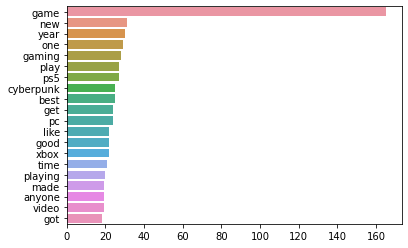

In [44]:
x, y= [], []
for i in range(20):
        x.append(total.index[i])
        y.append(total[i])
sns.barplot(x=y,y=x)

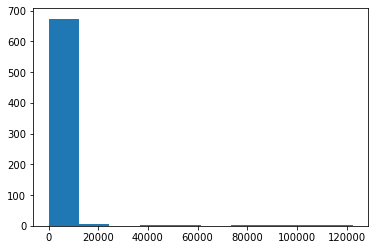

In [58]:
plt.hist(y1)
plt.show()

In [59]:
posts['score'].describe()

count       689.000000
mean       1170.432511
std        8690.940714
min           0.000000
25%           2.000000
50%           7.000000
75%          36.000000
max      122526.000000
Name: score, dtype: float64

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [46]:
corpus = posts['title'].tolist()

In [47]:
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english')

In [48]:
X = vectorizer.fit_transform(corpus)

In [49]:
X

<689x1898 sparse matrix of type '<class 'numpy.float64'>'
	with 3802 stored elements in Compressed Sparse Row format>

In [50]:
y1 = posts['score'].tolist()

In [51]:
vectorizer.get_feature_names()

['00',
 '000',
 '007',
 '10',
 '100',
 '1000',
 '1080p',
 '11',
 '12',
 '120',
 '120hz',
 '140',
 '144',
 '144hz',
 '15',
 '1500',
 '180',
 '1998',
 '19th',
 '20',
 '200',
 '2009',
 '2012',
 '2013',
 '2020',
 '2020s',
 '2021',
 '2077',
 '21',
 '22',
 '24',
 '2600',
 '27',
 '30',
 '360',
 '3d',
 '3v0',
 '40',
 '42',
 '43',
 '4da',
 '4k',
 '4s',
 '50',
 '53',
 '55',
 '550',
 '5500xt',
 '5he',
 '5yo',
 '60',
 '60frames',
 '60hz',
 '64',
 '700',
 '76',
 '8k',
 '99',
 '999',
 'a2',
 'abilities',
 'able',
 'absolute',
 'absurd',
 'abuse',
 'abused',
 'ac',
 'accident',
 'accomplishments',
 'account',
 'accuracy',
 'achievement',
 'achievements',
 'activision',
 'actor',
 'actually',
 'ad',
 'adaptation',
 'adapter',
 'add',
 'added',
 'adding',
 'admit',
 'ads',
 'adult',
 'advance',
 'adventure',
 'adventures',
 'advice',
 'aerial',
 'affects',
 'ago',
 'agree',
 'agrees',
 'ah',
 'ahead',
 'aim',
 'aiming',
 'ain',
 'airborne',
 'airlines',
 'alan',
 'alice',
 'alien',
 'alternative',
 'am

In [52]:
print(X)

  (0, 1831)	0.8359866530767514
  (0, 1253)	0.5487497752869985
  (1, 1881)	0.8548819893911651
  (1, 680)	0.5188224977914929
  (2, 590)	0.5773502691896257
  (2, 291)	0.5773502691896257
  (2, 627)	0.5773502691896257
  (3, 1845)	0.4578671394359298
  (3, 222)	0.4578671394359298
  (3, 1896)	0.43073950821481216
  (3, 950)	0.43073950821481216
  (3, 1425)	0.4578671394359298
  (4, 261)	0.6181820903168695
  (4, 1239)	0.6571147060945995
  (4, 1253)	0.431336488423683
  (5, 1851)	0.7180643163025777
  (5, 725)	0.6959767507991281
  (6, 16)	0.8410791764896774
  (6, 1874)	0.5409120250793527
  (7, 1444)	0.7071067811865475
  (7, 807)	0.7071067811865475
  (8, 1459)	0.47471671960635736
  (8, 1508)	0.47471671960635736
  (8, 376)	0.3878162056901461
  (8, 1287)	0.446590787442182
  :	:
  (683, 1761)	0.3459455916830514
  (683, 1781)	0.3459455916830514
  (683, 1305)	0.3459455916830514
  (683, 1822)	0.3459455916830514
  (683, 536)	0.3459455916830514
  (683, 1591)	0.31090655388481825
  (683, 1130)	0.207394357701771

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y1)

In [54]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [55]:
y_predict = clf.predict(X_test)

In [56]:
clf.score(X_test, y_test)

0.10982658959537572

In [57]:
y1

[4,
 17,
 43375,
 24001,
 784,
 2267,
 3778,
 2205,
 1716,
 108468,
 15336,
 391,
 163,
 139,
 109,
 1961,
 1101,
 103,
 69,
 886,
 133,
 1004,
 16395,
 58,
 57,
 2580,
 125,
 299,
 74,
 86742,
 827,
 49,
 84,
 38,
 153,
 150,
 954,
 412,
 129,
 99,
 35,
 2465,
 38,
 455,
 43,
 39,
 28,
 318,
 165,
 5907,
 22,
 299,
 1412,
 59661,
 2673,
 27,
 40,
 21,
 74,
 9801,
 129,
 31,
 19,
 122,
 21,
 15,
 18,
 26,
 44,
 66,
 32,
 14,
 54,
 10,
 65,
 25,
 10,
 12,
 10,
 19,
 13,
 61,
 34,
 10,
 61,
 10,
 50,
 12,
 10,
 15,
 25,
 26,
 9,
 128,
 29,
 37,
 32,
 7,
 65,
 11,
 67,
 5,
 206,
 6,
 208,
 6,
 29,
 191,
 7,
 5,
 79,
 79150,
 14,
 88,
 5,
 44,
 12,
 222,
 260,
 31,
 5,
 40,
 5,
 61,
 25,
 8,
 8,
 8,
 55623,
 6,
 17,
 13,
 4,
 4,
 22,
 34,
 16,
 15563,
 28,
 25,
 162,
 37,
 35,
 16273,
 26,
 9,
 3,
 34,
 18,
 44,
 22,
 17,
 4,
 4,
 5,
 131,
 13,
 5,
 3,
 42,
 36,
 1307,
 27,
 4,
 50,
 69,
 16,
 34,
 18,
 5,
 24,
 4,
 5,
 7,
 44,
 62,
 3,
 48,
 2,
 4,
 137,
 12431,
 122526,
 2,
 42,
 108,
 2

In [60]:
gnb = GaussianNB()

In [75]:
y_pred = gnb.fit(X_train.toarray(), y_train).predict(X_test.toarray())

In [77]:
print("Number of mislabeled points out of a total %d points : %d"
...       % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 173 points : 169
